# Membrane Model

A 2D model model with a shell in tube geometry. Counter-current plug flow with radial diffusion. Between the inner retentate side and the outside annular permeate side there is a membrane where a substance permeates.
The purpose of this example is to demonstrate how to couple submodels, either via explicit coupling, or fully implicit.

On both sides the governing equation is:

$\frac{\partial c}{\partial t} + \mathrm{div}_z (v \, c) - \mathrm{div}_r (D \, \mathrm{div}_r(c))  = 0$

On the retentate and permeate of the membrane we have boundary conditions:

$D \frac{\partial c_\mathrm{ret}}{\partial n} = P \, (c_\mathrm{perm} - c_\mathrm{ret})$, and $\frac{R_\mathrm{perm}}{R_\mathrm{ret}} D \frac{\partial c_\mathrm{perm}}{\partial n} =  P \, (c_\mathrm{ret} - c_\mathrm{perm})$.

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse.linalg as sla
from pymrm import construct_grad, construct_div, update_csc_array_indices, construct_convflux_upwind, construct_interface_matrices

L = 0.2
D = 1e-4
P = 0.002
c_in = 1.0
v_ret = 1e-1
v_perm = 1e-1
R_ret = 5e-3
R_perm = R_ret + 5e-4
R_out = 7e-3

num_z = 100
num_r_perm = 30
num_r_ret = 30
dz = L/num_z
z_f = np.linspace(0, L, num_z+1)
z_c = 0.5*(z_f[1:] + z_f[:-1])
r_f_ret = np.linspace(0, R_ret, num_r_ret+1)
r_c_ret = 0.5*(r_f_ret[1:] + r_f_ret[:-1])
r_f_perm = np.linspace(R_perm, R_out, num_r_perm+1)
r_c_perm = 0.5*(r_f_perm[1:] + r_f_perm[:-1])

bc_neumann = {'a': 1, 'b': 0, 'd': 0}
bc_dirichlet = {'a': 0, 'b': 1, 'd': 1}

shape_ret = (num_z, num_r_ret)
shape_perm = (num_z, num_r_perm)
shape_d = (num_z, 1)

div_ret_mat_z = construct_div(shape_ret, z_f, axis=0, nu=0)
div_ret_mat_r = construct_div(shape_ret, r_f_ret, axis=1, nu=1)
div_perm_mat_z = construct_div(shape_perm, z_f, axis=0, nu=0)
div_perm_mat_r = construct_div(shape_perm, r_f_perm, axis=1, nu=1)

conv_ret_mat, conv_ret_bc = construct_convflux_upwind(shape_ret, z_f, z_c, (bc_dirichlet, bc_neumann), v_ret, axis = 0)
conv_ret_bc *= c_in
conv_perm_mat, conv_perm_bc = construct_convflux_upwind(shape_perm, z_f, z_c, (bc_neumann, bc_dirichlet), -v_perm, axis = 0)
conv_perm_bc *= 0.0


In [6]:
from pymrm import compute_boundary_values

def print_balances():
    c_in_ret, _, c_out_ret, _  = compute_boundary_values(c_ret, z_f, z_c, ({'a':0, 'b': 1, 'd':c_in}, bc_neumann), axis=0)
    c_out_perm, _, c_in_perm, _  = compute_boundary_values(c_perm, z_f, z_c, (bc_neumann, {'a':0, 'b': 1, 'd':0}), axis=0)
    dA_r_ret = np.pi*(r_f_ret[1:]**2 - r_f_ret[:-1]**2).reshape((1,-1))
    dA_r_perm = np.pi*(r_f_perm[1:]**2 - r_f_perm[:-1]**2).reshape((1,-1))

    _, _, _, grad_mem_ret  = compute_boundary_values(c_ret, r_f_ret, r_c_ret, (bc_neumann, {'a':0, 'b': 1, 'd':c_b_ret}), axis=1)
    _ , grad_mem_perm, _, _  = compute_boundary_values(c_perm, r_f_perm, r_c_perm, ({'a':0, 'b': 1, 'd':c_b_perm}, bc_neumann), axis=1)
    dA_z_ret = 2*np.pi*R_ret*(z_f[1:] - z_f[:-1]).reshape((-1,1))
    dA_z_perm = 2*np.pi*R_perm*(z_f[1:] - z_f[:-1]).reshape((-1,1))

    flow_in_ret = v_ret*np.sum(c_in_ret*dA_r_ret, axis=1).reshape(())
    flow_out_ret = v_ret*np.sum(c_out_ret*dA_r_ret, axis=1).reshape(())
    flow_in_perm = v_perm*np.sum(c_in_perm*dA_r_perm, axis=1).reshape(())
    flow_out_perm = v_perm*np.sum(c_out_perm*dA_r_perm, axis=1).reshape(())
    flow_mem_ret = -D*np.sum(grad_mem_ret*dA_z_ret, axis=0).reshape(())
    flow_mem_perm = -D*np.sum(grad_mem_perm*dA_z_perm, axis=0).reshape(())

    print(f"retentate side: inlet molar flow = {flow_in_ret:.5e}, membrane molar flow out = {flow_mem_ret:.5e}, outlet molar flow = {flow_out_ret:.5e}")
    print(f"retentate balance: {flow_in_ret - flow_mem_ret - flow_out_ret:.5e}")
    print(f"permeate side:  inlet molar flow = {flow_in_perm:.5e}, membrane molar flow in  = {flow_mem_perm:.5e}, outlet molar flow = {flow_out_perm:.5e}")
    print(f"permeate balance: {flow_in_perm + flow_mem_perm - flow_out_perm:.5e}")
    print(f"overall balance: {flow_in_ret + flow_in_perm - flow_out_ret - flow_out_perm:.5e}")


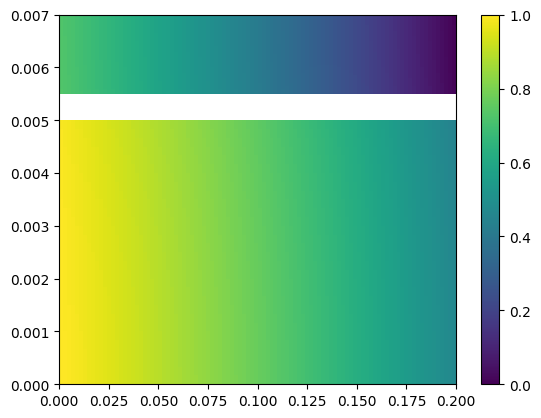

retentate side: inlet molar flow = 7.85398e-06, membrane molar flow out = 4.27250e-06, outlet molar flow = 3.58148e-06
retentate balance: -1.94818e-20
permeate side:  inlet molar flow = 0.00000e+00, membrane molar flow in  = 4.27072e-06, outlet molar flow = 4.27178e-06
permeate balance: -1.06154e-09
overall balance: 7.24578e-10


In [7]:
# Explicit coupling
from pymrm import compute_boundary_values
import copy

num_iter = 20
c_ret = np.zeros(shape_ret)
c_perm = np.zeros(shape_perm)
c_b_ret = np.zeros((num_z, 1))
c_b_perm = np.zeros((num_z, 1))

bc_mem_ret = {'a': D, 'b': P, 'd': P}
bc_r_ret = (bc_neumann, bc_mem_ret)
bc_mem_perm = {'a': R_perm/R_ret*D, 'b': P, 'd': P}
bc_r_perm = (bc_mem_perm, bc_neumann)

grad_ret_mat, _, grad_ret_bc = construct_grad(shape_ret, r_f_ret, r_c_ret, bc_r_ret, axis = 1, shapes_d = (None, shape_d))
grad_perm_mat, grad_perm_bc, _ = construct_grad(shape_perm, r_f_perm, r_c_perm, bc_r_perm, axis = 1, shapes_d = (shape_d, None))

jac_ret_mat = div_ret_mat_z @ conv_ret_mat - D*div_ret_mat_r @ grad_ret_mat
jac_ret_lu = sla.splu(jac_ret_mat)
jac_perm_mat = div_perm_mat_z @ conv_perm_mat - D*div_perm_mat_r @ grad_perm_mat
jac_perm_lu = sla.splu(jac_perm_mat)

rhs_ret_bc_const = -div_ret_mat_z @ conv_ret_bc
rhs_perm_bc_const = -div_perm_mat_z @ conv_perm_bc
jac_ret_bc = D*div_ret_mat_r @ grad_ret_bc
jac_perm_bc = D*div_perm_mat_r @ grad_perm_bc
bc_r_ret_interp = copy.deepcopy(bc_r_ret)
bc_r_perm_interp = copy.deepcopy(bc_r_perm)

for i in range(num_iter):
    bc_r_ret_interp[1]['d'] = bc_r_ret[1]['d']*c_b_perm
    bc_r_perm_interp[0]['d'] = bc_r_perm[0]['d']*c_b_ret
    _, _, c_b_ret, _  = compute_boundary_values(c_ret, r_f_ret, r_c_ret, bc_r_ret_interp, axis=1)
    c_b_perm, _, _, _ = compute_boundary_values(c_perm, r_f_perm, r_c_perm, bc_r_perm_interp, axis=1)
    rhs_ret_bc = rhs_ret_bc_const + jac_ret_bc @ c_b_perm.reshape(-1,1)
    rhs_perm_bc= rhs_perm_bc_const +  jac_perm_bc @ c_b_ret.reshape(-1,1)
    c_ret[:]   = jac_ret_lu.solve(rhs_ret_bc).reshape(shape_ret)
    c_perm[:]  = jac_perm_lu.solve(rhs_perm_bc).reshape(shape_perm)

_, _, c_b_ret, _  = compute_boundary_values(c_ret, r_f_ret, r_c_ret, bc_r_ret_interp, axis=1)
c_b_perm, _, _, _ = compute_boundary_values(c_perm, r_f_perm, r_c_perm, bc_r_perm_interp, axis=1)
    
plt.pcolormesh(z_f, r_f_ret, c_ret.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)
plt.pcolormesh(z_f, r_f_perm, c_perm.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)

plt.colorbar()
plt.show()

print_balances()


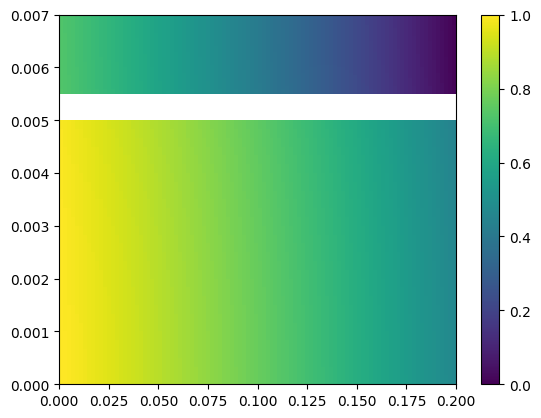

retentate side: inlet molar flow = 7.85398e-06, membrane molar flow out = 4.27200e-06, outlet molar flow = 3.58198e-06
retentate balance: -3.45166e-19
permeate side:  inlet molar flow = 0.00000e+00, membrane molar flow in  = 4.27200e-06, outlet molar flow = 4.27200e-06
permeate balance: -7.64363e-18
overall balance: -1.00873e-17


In [8]:
# Implicit coupling

c_all = np.zeros((num_z, num_r_ret + num_r_perm))
c_ret = c_all[:, :num_r_ret]
c_perm = c_all[:, num_r_ret:]
c_vect = c_all.reshape((-1,1))

shape_ret = c_ret.shape
shape_perm = c_perm.shape
shape_d = (num_z, 1)

# interface conditions:
ic_1 = {'a':(D,0), 'b':(P,-P), 'd':0}
ic_2 = {'a':(0,R_perm/R_ret*D), 'b':(-P,P), 'd':0}
interf_mat_ret, _, interf_mat_perm, _ = construct_interface_matrices((shape_ret, shape_perm), (r_f_ret, r_f_perm), ic=(ic_1, ic_2), axis=1)

grad_ret_mat_coupled, _, grad_ret_bc_coupled = construct_grad(shape_ret, r_f_ret, r_c_ret, bc = (bc_neumann, bc_dirichlet), axis = 1, shapes_d = (None, shape_d))
jac_ret_mat_coupled = div_ret_mat_z @ conv_ret_mat - D*div_ret_mat_r @ grad_ret_mat_coupled
rhs_ret_bc_coupled  = -div_ret_mat_z @ conv_ret_bc
rhs_ret_ic  = D*div_ret_mat_r @ grad_ret_bc_coupled
jac_ret_ic  = -D*div_ret_mat_r @ grad_ret_bc_coupled @ interf_mat_ret
jac_ret_mat_coupled = update_csc_array_indices(jac_ret_mat_coupled, shape_ret, c_all.shape, offset=None)
rhs_ret_ic = update_csc_array_indices(rhs_ret_ic, (shape_ret, None), (c_all.shape, None), offset=None)
jac_ret_ic = update_csc_array_indices(jac_ret_ic, (shape_ret, None), (c_all.shape, None), offset=None)
rhs_ret_bc_coupled = update_csc_array_indices(rhs_ret_bc_coupled, (shape_ret, None), (c_all.shape, None), offset=None)

grad_perm_mat_coupled, grad_perm_bc_coupled, _ = construct_grad(shape_perm, r_f_perm, r_c_perm, bc=(bc_dirichlet, bc_neumann), axis = 1, shapes_d = (shape_d, None))
jac_perm_mat_coupled = div_perm_mat_z @ conv_perm_mat - D*div_perm_mat_r @ grad_perm_mat_coupled
rhs_perm_bc_coupled  = -div_perm_mat_z @ conv_perm_bc*0
rhs_perm_ic  = D*div_perm_mat_r @ grad_perm_bc_coupled
jac_perm_ic  = -D*div_perm_mat_r @ grad_perm_bc_coupled @ interf_mat_perm
jac_perm_mat_coupled = update_csc_array_indices(jac_perm_mat_coupled, shape_perm, c_all.shape, offset=(0,shape_ret[1]))
rhs_perm_ic = update_csc_array_indices(rhs_perm_ic, (shape_perm, None), (c_all.shape, None), offset=((0,shape_ret[1]),None))
jac_perm_ic = update_csc_array_indices(jac_perm_ic, (shape_perm, None), (c_all.shape, None), offset=((0,shape_ret[1]),None))
rhs_perm_bc_coupled = update_csc_array_indices(rhs_perm_bc_coupled, (shape_perm, None), (c_all.shape, None), offset=((0,shape_ret[1]),None))

jac_coupled = jac_ret_mat_coupled + jac_perm_mat_coupled + jac_ret_ic + jac_perm_ic
jac_coupled_lu = sla.splu(jac_coupled)
rhs_coupled = rhs_ret_bc_coupled + rhs_perm_bc_coupled
rhs = rhs_coupled.toarray()

c_all[:] = jac_coupled_lu.solve(rhs).reshape(c_all.shape)
c_b_ret = interf_mat_ret @ c_vect
c_b_perm = interf_mat_perm @ c_vect


plt.pcolormesh(z_f, r_f_ret, c_ret.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)
plt.pcolormesh(z_f, r_f_perm, c_perm.transpose(), shading='flat', cmap='viridis', vmin=0, vmax=c_in)
plt.colorbar()
plt.show()

print_balances()
